# El Modelo Neoclásico Estocástico de Crecimiento

## Programación Dinámica: iteración de la función valor

In [1]:
# Librerías
import numpy as np # Álgebra Lineal
import matplotlib.pyplot as plt # Gráficas
from scipy.interpolate import interp1d # Interpolación lineal
from scipy.optimize import minimize_scalar # Maximización escalar
from copy import copy 

### El Problema de Opmización del planificador

Utilizando preferencias CRRA para las familias y una función de producción Cobb-Douglas, el problema de optimización del planificador es:

\begin{align*}
\max_{\{ c_t , k_t \}_{t=0}^{\infty}} U_{0} &= E_0 \sum_{t=0}^{\infty}\beta^{t}\left(\frac{c_{t}^{1-\sigma}-1}{1-\sigma}\right)\\
s.a: \; \;  c_{t} + i_{t} &= A_t k_{t}^{\alpha} \\
     k_{t+1} &= i_{t}+(1-\delta)k_{t} \\
    & dado \; k_{0}
\end{align*}

Colapsando las restricciones en una sola, es posible escribir el problema como:

\begin{align*}
\max_{\{ c_t , k_t \}_{t=0}^{\infty}} U_{0} &= E_0 \sum_{t=0}^{\infty}\beta^{t}\left(\frac{c_{t}^{1-\sigma}-1}{1-\sigma}\right)\\
s.a: \; \;  c_{t} + k_{t+1} &= A_t k_{t}^{\alpha} + (1-\delta)k_t \\
 & dado \; k_{0}
\end{align*}

En cuanto a la productividad, es una cadena de Markov con espacio de estados 
$$ S = \{A_L,A_H\} $$ 

y matriz de transición
$$ P = \begin{bmatrix} p & 1-p \\ 1-q & q  \end{bmatrix} $$

donde $\Pr(A_L|A_L) = p$ y $\Pr(A_H|A_H) = q$

### Las Condiciones de Primer Orden

La función de valor es
\begin{align*}
    V(A_t, k_t) = \max_{ \{ k_{t+1} \} } \left[  \dfrac{ \left( \overbrace{A_t k_{t}^{\alpha} + (1-\delta)k_t - k_{t+1}}^{c_t} \right)^{1-\sigma} - 1}{1-\sigma} + \beta E_t V(A_{t+1}, k_{t+1})  \right]
\end{align*}

Las CPO para consumo y capital son, respectivamente:

\begin{align*}
c_{t}^{-\sigma} &=  \beta E_t c_{t+1}^{-\sigma}\left[\alpha A_{t+1} k_{t+1}^{\alpha-1}+(1-\delta)\right]\\
c_{t}+k_{t+1}   &=  A_t k_{t}^{\alpha}+(1-\delta)k_{t}
\end{align*}

### Estado Estacionario 

Como primer paso para caracterizar el estado estacionario encontramos el valor esperado de largo plazo de $A$, el proceso tecnológico. 

La distribución invariante cumple
$$ \begin{bmatrix} \mu_L & \mu_H \end{bmatrix} = \mu = \mu P $$

Podemos notar que $\mu$ es el vector propio asociado al valor propio igual a $1$ (ajustado de manera que sus elementos sumen $1$). Lo desarrollamos en python de la siguiente manera con un ejemplo numérico


In [2]:
# Matriz de transición
p = .65 ; q = .65
P = np.array([ [p , 1-p] , [1-q , q]  ])

eig_vals_P, eig_vecs_P = np.linalg.eig(P)

print("Valores propios P:", eig_vals_P)
print("Vectores propios P:", eig_vecs_P)

Valores propios P: [1.  0.3]
Vectores propios P: [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [3]:
# El valor propio igual a 1 es el primero, de manera que utilizaremos la primera columna en la matriz de vectores propios
# Ajustamos los valores del vector propio de manera que sus componentes sumen 1

pi_0 = eig_vecs_P[:,0] / np.abs(eig_vecs_P[:,0]).sum()
print("La distribución invariante es: ", pi_0)

La distribución invariante es:  [0.5 0.5]


Ya que hemos encontrado $\mu_L = \mu_H = 0.5$, podemos calcular el estado estacionario. Para esto, eliminamos el índice $t$ en las CPO

\begin{align*}
1 & = \beta E \left[\alpha A k^{\alpha-1}_{EE}+(1-\delta)\right]\\
c_{EE} & = E[A] k^{\alpha}_{EE}-\delta k_{EE}
\end{align*}

Donde $E[A] = \mu_L A_L + \mu_H A_H$

Desarrollando:

\begin{align*}
k_{EE} & = \left[\frac{1-\beta(1-\delta)}{\beta\alpha E[A]}\right]^{\frac{1}{\alpha-1}}\\
c_{EE} & = E[A]\left[\frac{1-\beta(1-\delta)}{\beta\alpha E[A]}\right]^{\frac{\alpha}{\alpha-1}}-\delta\left[\frac{1-\beta(1-\delta)}{\beta\alpha E[A]}\right]^{\frac{1}{\alpha-1}}
\end{align*}

In [4]:
# Ejemplo 
AL = 0.8   # tecnologia en estado bajo
AH = 1.2   # tecnologia en estado alto
S  = [AL, AH]
EA = pi_0[0]*AL + pi_0[1]*AH # E[A]
alpha = 0.36   # participacion del capital   
beta  = 0.9    # factor de descuento  
delta = 1.0    # depreciación capital
sigma = 1.0     # Parámetro función de utilidad

# Capital de estado estacionario
k_EE = ((1 - beta*(1-delta)) / (beta*alpha*EA))**(1/(alpha-1))
c_EE = EA*k_EE**alpha - delta*k_EE 

print("El capital de estado estacionario es: ", k_EE)
print("El consumo de estado estacionario es: ", c_EE)

El capital de estado estacionario es:  0.17188048815558038
El consumo de estado estacionario es:  0.3586148456579394


### Funciones de política: iteración de la función valor

Para encontrar las funciones de política llevaremos a cabo iteración de la función valor. Para esto, necesitamos reescribir la función valor indicando explícitamente la expectativa y los estados para el proceso tecnológico

\begin{align*}
    V(A_L, k_t) = \max_{ \{ k_{t+1} \} } \left[  \dfrac{ \left( A_L k_{t}^{\alpha} + (1-\delta)k_t - k_{t+1} \right)^{1-\sigma} - 1}{1-\sigma} + \beta \big\{ p V(A_{L}, k_{t+1}) + (1-p) V(A_{H}, k_{t+1}) \big\} \right]
\end{align*}

\begin{align*}
    V(A_H, k_t) = \max_{ \{ k_{t+1} \} } \left[  \dfrac{ \left( A_H k_{t}^{\alpha} + (1-\delta)k_t - k_{t+1} \right)^{1-\sigma} - 1}{1-\sigma} + \beta \big\{ q V(A_{H}, k_{t+1}) + (1-q) V(A_{L}, k_{t+1}) \big\} \right]
\end{align*}

El algoritmo utilizado realiza las siguientes tareas:

1. Dada una grilla de valores para $k$ y una conjetura para $V^{0}(A,k)$, maximiza las funciones descritas, para cada valor de $A$ y $k$ posibles. 
2. De la maximización anterior se obtiene $V^{1}(A,k)$. Si $V^{0}(A,k) = V^{0}(A,k)$ (con un criterio de tolerancia) se ha encontrado la solución al problema. En caso contrario se itera nuevamente (volver al paso 1) utilizando como conjetura $V^{1}(A,k)$

In [5]:
# Función de utilidad 
def u(c):
    if sigma < 0:
        raise Exception("Sigma debe ser mayor o igual a cero")
    if int(sigma) == 1:
        utilidad = np.log(c)
    else:
        utilidad = (c**(1-sigma) - 1) / (1-sigma)
    return utilidad

# Tamaño de la grilla
n = 100

# Grilla para el capital
k_grid = np.linspace(1e-5, 5*k_EE, n)  

# Conjetura Inicial para la función valor
v0 = np.zeros((n,2))

In [6]:
diferencia = np.inf
v1   = np.zeros((n,2))  # Función valor de la siguiente iteración
kpol = np.zeros((n,2))  # Función de política para el capital
crit = 1e-6

while diferencia > crit:

    for j in [0,1]:
        
        A  = S[j]
        
        # Interpolación para la función valor
        vL = interp1d(k_grid, v0[:,0], fill_value="extrapolate")
        vH = interp1d(k_grid, v0[:,1], fill_value="extrapolate")

        Tv = lambda k,k_: u(A*k**alpha + (1-delta)*k - k_) + beta*( P[j,0]*vL(k_) + P[j,1]*vH(k_) )

        for i in range(n):
            opt = minimize_scalar(lambda x: -Tv(k_grid[i],x), bounds=(1e-6, A*k_grid[i]**alpha + (1-delta)*k_grid[i]), method='bounded') 
            kpol[i,j] = opt.x
            v1[i,j] = -opt.fun

    diferencia = np.abs(np.max(v1-v0))      
    v0 = copy(v1) 

print("Convergencia = ", diferencia)

Convergencia =  9.69879605960955e-07


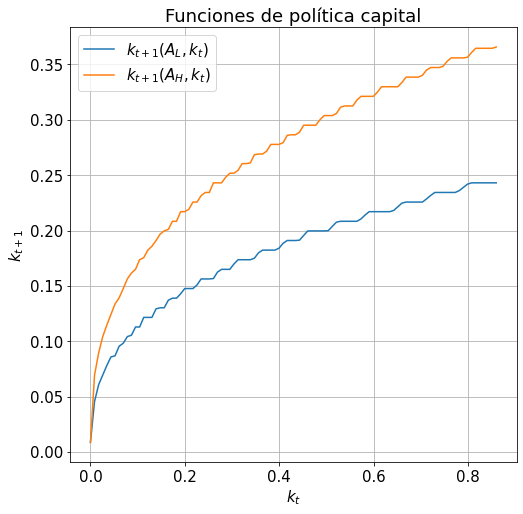

In [7]:
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(8,8))
plt.plot(k_grid, kpol[:,0], label = r"$k_{t+1}(A_L, k_t)$")
plt.plot(k_grid, kpol[:,1], label = r"$k_{t+1}(A_H, k_t)$")
plt.xlabel(r"$k_t$") ; plt.ylabel(r"$k_{t+1}$") ; plt.title("Funciones de política capital")
plt.grid() ; plt.legend()
plt.show()

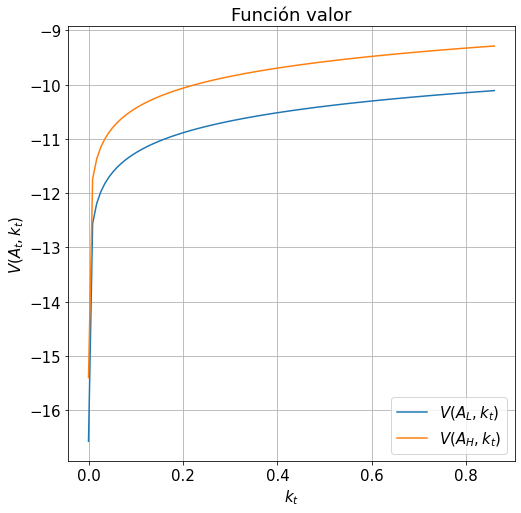

In [8]:
plt.figure(figsize=(8,8))
plt.plot(k_grid, v1[:,0], label = r"$V(A_L, k_t)$")
plt.plot(k_grid, v1[:,1], label = r"$V(A_H, k_t)$")
plt.xlabel(r"$k_t$") ; plt.ylabel(r"$V(A_t, k_t)$") ; plt.title("Función valor")
plt.grid() ; plt.legend()
plt.show()